In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data: `run-pgdl-da`

In [2]:
data = np.load("../run-pgdl-da/2_model_prep/out/data_train[1985-05-01.2021-04-14]_1573.npz", allow_pickle = True)

In [3]:
# Usually 31 ensembles, over many many days, 1 target variable
data['obs_trn'].shape

(31, 13132, 1)

In [4]:
# Let's just use 1 ensemble and the last 2000 days (which are NaN free)
x = torch.from_numpy(data['x_trn_fine']).float()[0, -2000:]
y = torch.from_numpy(data['obs_trn']).float()[0, -2000:]

y = (y - y.mean()) / y.std()

x.shape, y.shape

(torch.Size([2000, 6]), torch.Size([2000, 1]))

# Define a simple model

In [5]:
class ANN(torch.nn.Module):
    
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = torch.nn.Linear(x.shape[1], 100)
        self.fc2 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return(x)

# Make it
model = ANN()

In [6]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

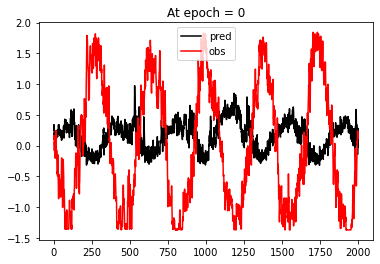

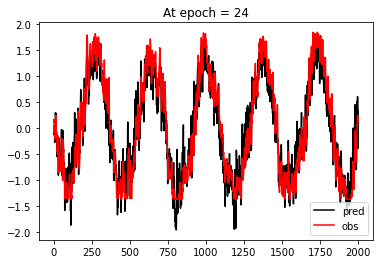

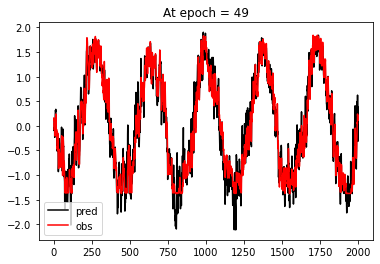

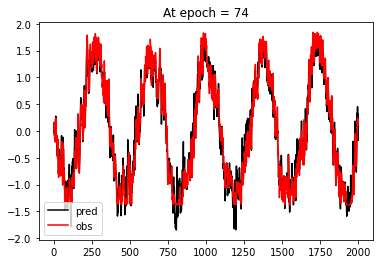

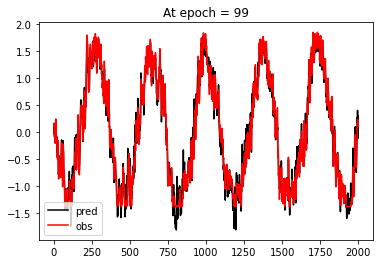

In [7]:
for i in range(100):
    out = model(x)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 25 == 0 or i == 0:
        plt.plot(out.detach(), color = 'black', label = 'pred')
        plt.plot(y, color = 'red', label = 'obs')
        plt.legend()
        plt.title('At epoch = ' + str(i))
        plt.show()
        plt.pause(0.001)

# Apply XAI

In [8]:
import shap

In [9]:
%%time
explainer = shap.GradientExplainer(model, x)

shap_values = explainer.shap_values(x)
shap_values.shape

Wall time: 44.5 s


(2000, 6)

### Explore various visualization options

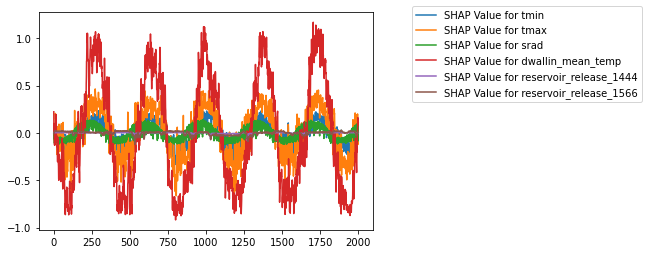

In [10]:
for i in range(x.shape[1]):
    plt.plot(shap_values[:, i], label = 'SHAP Value for ' + data['x_vars_trn'][i])
    plt.legend(bbox_to_anchor=(1.1, 1.05));

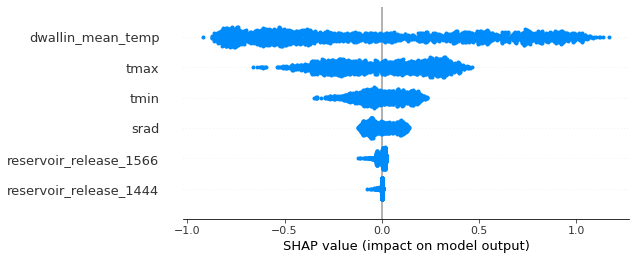

In [11]:
shap.summary_plot(shap_values, data['x_vars_trn'])

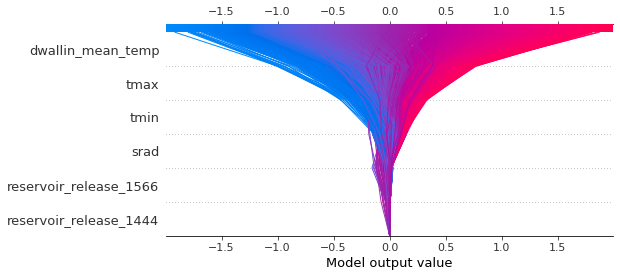

In [12]:
shap.decision_plot(torch.mean(y).item(), shap_values, data['x_vars_trn'])

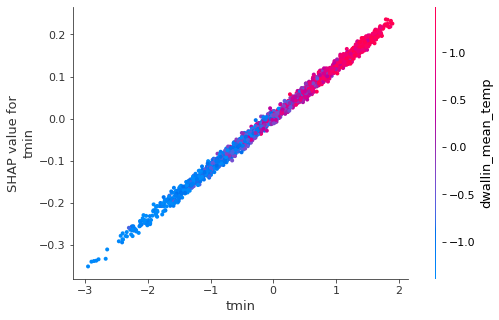

In [13]:
shap.dependence_plot(0, shap_values, x.numpy(), data['x_vars_trn'])

In [14]:
shap.plots.force(torch.mean(y).item(), shap_values[0])